# "fastai DataBlock API from Foundations"
> TODO SUMMARY
- toc: true
- comments: true
- author: Kushajveer Singh
- categories: [notes]
- badges: true

In [1]:
#hide
from nbdev.showdoc import show_doc
from fastai.callback.fp16 import to_fp16

In [2]:
# Handles all the necessary imports
from fastai.vision.all import *

## Get dataset
For this post I use [Imagewoof](https://github.com/fastai/imagenette) dataset. There is nothing special here. It is an ImageNet style dataset and will provide a good basis for the post.

In [3]:
path = Path('/home/kushaj/Desktop/Data/imagewoof2/')
Path.BASE_PATH = path
path.ls()

(#2) [Path('train'),Path('val')]

In [4]:
!tree {path} -L 2

/home/kushaj/Desktop/Data/imagewoof2
├── train
│   ├── n02086240
│   ├── n02087394
│   ├── n02088364
│   ├── n02089973
│   ├── n02093754
│   ├── n02096294
│   ├── n02099601
│   ├── n02105641
│   ├── n02111889
│   └── n02115641
└── val
    ├── n02086240
    ├── n02087394
    ├── n02088364
    ├── n02089973
    ├── n02093754
    ├── n02096294
    ├── n02099601
    ├── n02105641
    ├── n02111889
    └── n02115641

22 directories, 0 files


## PyTorch `Dataset` class
The base class to get items from the dataset. It is an instance of `torch.utils.data.Dataset`. fastai does not do anything special here. The same dataset class used in PyTorch can be used here.

Let's start by defining the `Dataset` class for training and validation dataset. What do we need this class to do?

It should get the name of image files. And that is it. The reason being the `DataLoader` class in fastai is very powerful (as we will soon see).

> Note: To avoid messing up with fastai imports I use a underscore (\_) in front of class names.

In [5]:
class _Dataset(torch.utils.data.Dataset):
    def __init__(self, path): self.items = get_image_files(path)
    def __len__(self)       : return len(self.items)
    def __getitem__(self, i): return self.items[i]
    
dataset = {
    'train': _Dataset(path/'train'),
    'valid': _Dataset(path/'val'),
}

In [6]:
len(dataset['train']), len(dataset['valid'])

(9025, 3929)

In [7]:
dataset['train'][1]

Path('train/n02111889/n02111889_11223.JPEG')

## Create `DataLoader`
The base dataloader class defined in `fastai.data.load.DataLoader` forms the basis of fastai DataBlock API.

Please refer to my previous post [Deep dive into fastai DataLoader methods](https://kushajveersingh.github.io/blog/notes/2020/09/05/post-0013.html) which provides a 2 minute summary of all the important methods of `DataLoader` class.

From this point I assume you are comfortable with the methods available in `DataLoader` class and in what order they operate.

Now let's start creating our `DataLoader`.

### Get (image, label) tuple from filename
This can be done using `after_item`. We need to read the image from disk and resize to a fixed size (224,224 for this example) and extract label of the image. For the labels, I manually create a dictionary to map folder name to integer.

At this point we are still limiting ourselves by not using `Transform`s. We will use them in the next section.

In [8]:
vocab = {
    'n02086240':0,
    'n02087394':1,
    'n02088364':2,
    'n02089973':3,
    'n02093754':4,
    'n02096294':5,
    'n02099601':6,
    'n02105641':7,
    'n02111889':8,
    'n02115641':9,
}

In [9]:
def after_item(item):
    # `item` here is dataset[idx] i.e. image file path
    img = Image.open(item).convert('RGB').resize((224,224))
    img = image2tensor(img)
    lbl = vocab[item.parent.name]
    return img, lbl

In [10]:
after_item(dataset['train'][1])

(tensor([[[103, 105, 107,  ...,  85,  86,  89],
          [105, 105, 105,  ...,  81,  78,  81],
          [109, 109, 109,  ...,  85,  83,  83],
          ...,
          [ 50,  44,  39,  ...,  70,  66,  66],
          [ 47,  51,  57,  ...,  63,  60,  70],
          [ 43,  49,  45,  ...,  58,  60,  56]],
 
         [[ 77,  79,  82,  ...,  53,  53,  53],
          [ 78,  78,  80,  ...,  48,  48,  49],
          [ 80,  80,  82,  ...,  49,  48,  48],
          ...,
          [122, 113, 102,  ..., 142, 137, 137],
          [106, 116, 132,  ..., 136, 137, 139],
          [ 85, 104,  98,  ..., 134, 136, 137]],
 
         [[ 55,  57,  59,  ...,  38,  34,  32],
          [ 55,  56,  56,  ...,  34,  31,  33],
          [ 61,  61,  63,  ...,  32,  32,  34],
          ...,
          [118, 107,  99,  ..., 148, 145, 144],
          [104, 113, 130,  ..., 142, 143, 146],
          [ 69,  90,  91,  ..., 140, 143, 144]]], dtype=torch.uint8),
 8)

### Apply some transforms
This is where power of fastai comes into play. We can define the transforms to apply on CPU or on a complete batch on the GPU. `after_item` can also be considered a form of transform. 

To apply transforms on the complete batch on the GPU we use `after_batch`. For our example, we need to convert the image tensor to float and then normalize the tensor using imagenet mean and std.

In [11]:
def after_batch(b):
    # `b` is a tuple of (image, label) 
    # `image` of shape [batch_size, num_channels, height, width]
    # `label` of shape [batch_size]
    device = torch.device('cuda')
    
    # move the batch to GPU
    b = to_device(b, device)
    imgs, lbls = b
    
    # convert `imgs` to float
    imgs = imgs.div(255.)
    
    # normalize data
    mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1,3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225], device=device).view(1,3,1,1)
    imgs = (imgs - mean) / std
    
    return imgs,lbls

### Create `DataLoader`
Now we are ready to create a `DataLoader` for training and validation dataset.

In [12]:
def get_dataloader(dataset, shuffle):
    return DataLoader(dataset,
                      bs=64,
                      num_workers=12,
                      shuffle=True,
                      after_item=after_item,
                      after_batch=after_batch)

dl = {
    'train': get_dataloader(dataset['train'], shuffle=True),
    'valid': get_dataloader(dataset['valid'], shuffle=False),
}

dls = DataLoaders(dl['train'], dl['valid'], device=torch.device('cuda'))

`DataLoaders` is just a wrapper around a list of `DataLoader`s. It handles all the internal things that are necessary to use training and validation dataloader in `Learner`.

And that is it. Now we can create a learner.

In [13]:
learn = Learner(dls, 
                xresnet18(), 
                loss_func=CrossEntropyLossFlat(),
                pretrained=False, 
                metrics=[accuracy]).to_fp16()

In [14]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,2.497939,2.082149,0.271570,00:14
1,1.853111,1.753154,0.378977,00:12
2,1.562037,1.554112,0.455332,00:12


## Summary till now
Ideally, we are done. We can do almost anything by just using the `DataLoader` class. But we can still improve on some things. Consider the `after_batch` function that we defined above

```python
def after_batch(b):
    # `b` is a tuple of (image, label) 
    # `image` of shape [batch_size, num_channels, height, width]
    # `label` of shape [batch_size]
    device = torch.device('cuda')
    b = to_device(b, device)
    imgs, lbls = b
    
    # convert `imgs` to float
    imgs = imgs.div(255.)
    
    # normalize data
    mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1,3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225], device=device).view(1,3,1,1)
    imgs = (imgs - mean) / std
    
    return imgs,lbls
```

We can summarize the above function as performing 3 steps
1. Move batch to GPU.
2. Convert integer tensor to float.
3. Normalize the data.

Now imagine if we had to add code for data augmentation or we wanted to define different functions for the training and validation split (we do not want to apply data augmentation to validation set). This can quickly get out of hand.

This is where fastai's [Type Dispatch](https://fastcore.fast.ai/dispatch.html) and [Transform](https://fastcore.fast.ai/transform.html) comes into play. These are incredibly powerful tools. 

## The real thing begins
This section defines how you can define your own `DataBlock` with all the bells and whistles of fastai.

For every item in the `DataLoader` we need to a define a type (i.e. `class` in python) for that item. In the previous section the `DataLoader` consists of `(image, label)`. So we need to define a base class for these two things. Why are we doing this?

There are two reasons:
1. The base class knows how to create the object. In case of image, the base class would know how to open the image from disk.
2. The base class knows how to show the object. In case of image, it would know how to plot the image.

From model training perspective it is not important to define a `show` method because it does nothing for training the model. But defining this method can be considered a good practice. This `show` method allows you to use methods like `show_batch`, `show_results` and more which can come handy during debugging of your model and for interpretation of the results.

After creating the base class we also need to create a `Block` from that class. This stores all the default transforms for that base class.

Let's start.

### Create base class (PILImage)
```python
class _PILImage(Image.Image, metaclass=BypassNewMeta)
```
Using `metaclass=BypassNewMeta` is important. You can read about this class [here](https://fastcore.fast.ai/foundation.html#BypassNewMeta). In short, it avoids recreating the object passed to constructor.

`Image.Image`. As we are dealing with images and `PIL` is a very good library to handle images, we can build upon this library. 

In [26]:
class _PILImage(Image.Image, metaclass=BypassNewMeta):
    @classmethod
    def create(cls, path)->None: return cls(Image.open(path).convert('RGB'))
    def show(self): plt.imshow(self)

This is the simplest definition of an ImageBlock. It knows how to create an image from a filename and how to show the image.

> Note: Do not forget to wrap `Image.open(path)` using `cls`. Otherwise the returned object would be of type `PIL.Image.Image`.

In [27]:
img_path = path/'train'/'n02086240'/'ILSVRC2012_val_00000907.JPEG'
img = _PILImage.create(img_path)

In [28]:
type(img)

__main__._PILImage

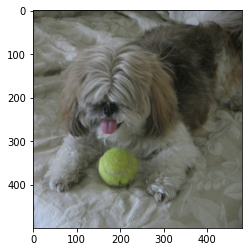

In [29]:
img.show()

### Create block (ImageBlock)
Now we need to add some information on what transforms should be applied by default whenever we use this base class (`_PILImage`). In case of image, the image needs to be converted to float before passing through the model. This information can be added in a `Block`.

First, let's define a transform that coverts input image to float.

In [30]:
class _IntToFloatTensor(DisplayedTransform):
    def encodes(self, o): return o.float().div_(255.)
    def decodes(self, o): return (o.clamp(0., 1.)*255.).long()

Defining a `Transform` in fastai requires you to define two main function.
* `encodes`: how to get from input to output
* `decodes`: how to get from output to input

Defining `decodes` is not important from a model training perspective. But it is a good practice. Without this method you cannot use various `show` methods that comes with `DataLoader`.

In [31]:
tfm = _IntToFloatTensor()
tfm

_IntToFloatTensor -- {}:
encodes: (object,object) -> encodes
decodes: (object,object) -> decodes

[DisplayedTransform](https://fastcore.fast.ai/transform.html#DisplayedTransform) is same as `Transform`. It just adds a `__repr__` method on top of `Transform`.

> Important: If you want the transform to be only applied to training split, use `split_idx=0` in the `Transform` definition as shown below.

In [33]:
class SomeTransform(Transform):
    split_idx=0 # only applied to training dataset
    split_idx=1 # only applied to validation dataset
    
    def encodes(self): pass
    def decodes(self): pass

Now to combine the base class and transforms, we use [TransformBlock](https://docs.fast.ai/data.block.html#TransformBlock).

In [35]:
def _ImageBlock(cls=_ImageBlock):
    return TransformBlock(type_tfms=cls.create,
                          batch_tfms=[_IntToFloatTensor])

And this is it. Using the above steps you can easily create any **Block** for your particular application. Now we can pass `_ImageBlock` in `DataBlock`.